In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

# load torch

In [3]:
import torch
import torch.nn.functional as F
from torch.cuda import amp
import numpy as np

In [4]:
from rbg720.remove_bg_utils import load_checkpoint_mgpu
from rbg720.remove_bg_utils import U2NET

In [5]:
checkpoint_path = '../weights/rbg_interior/interior.pth'

In [6]:
device='cuda'

In [7]:
rbg = U2NET(in_ch=3, out_ch=1)
rbg = load_checkpoint_mgpu(rbg, checkpoint_path)
rbg = rbg.eval()
rbg = rbg.to(device)

----checkpoints loaded from path: ../weights/rbg_interior/interior.pth----


# load tf

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
from WindowCorrection.config import *
from WindowCorrection.dataloader import *
from WindowCorrection.model.u2net import *

In [11]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
inputs = keras.Input(shape=(768, 768, 3), name="INPUT__0")
net = U2NET()
out = net(inputs)
model = keras.Model(inputs=inputs, outputs=out, name='u2netmodel')
model.compile(optimizer=adam, loss=bce_loss, metrics=None)

2022-01-02 22:22:41.881449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-02 22:22:42.731191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13543 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [13]:
checkpoint_path = '../weights/window_tint/u2net.h5'
model.load_weights(checkpoint_path)

# Convert Weights

In [15]:
totc = 0
totb = 0
for a,b in zip(list(rbg.named_parameters()), model.trainable_weights):
    assert a[1].dtype is torch.float32 and b.dtype is tf.float32
    if '.conv_' in a[0] or a[0][:4]=='side' or 'outconv' in a[0]:
        assert 'conv2d' in b.name, f'{a[0]}, {b.name}'
        if 'kernel' in b.name:
            assert '.weight' in a[0], f'{a[0]}, {b.name}'
            p = b.numpy().transpose(3,2,0,1)
            assert a[1].shape == p.shape
            a[1].data.copy_(torch.from_numpy(p))
            totc+=1
        elif 'bias' in b.name:
            assert '.bias' in a[0], f'{a[0]}, {b.name}'
            p = b.numpy()
            assert a[1].shape == p.shape
            a[1].data.copy_(torch.from_numpy(p))
            totc+=1
        else:
            print(a,b)
    elif '.bn_' in a[0]:
        assert '/batch_normalization' in b.name, f'{a[0]}, {b.name}'
        if 'gamma' in b.name:
            assert '.weight' in a[0], f'{a[0]}, {b.name}'
            p = b.numpy()
            assert a[1].shape == p.shape
            a[1].data.copy_(torch.from_numpy(p))
            totb+=1
        elif 'beta' in b.name:
            assert '.bias' in a[0], f'{a[0]}, {b.name}'
            p = b.numpy()
            assert a[1].shape == p.shape
            a[1].data.copy_(torch.from_numpy(p))
            totb+=1
        else:
            print(a,b)
    else:
        print(a[0],b.name)

# For BN running mean and var
for m,n in zip([i for i in rbg.buffers() if len(i.shape)>0], model.non_trainable_weights):
    m.copy_(torch.from_numpy(n.numpy()))

In [18]:
totc + totb, len(list(rbg.named_parameters())), len(model.trainable_weights)

(462, 462, 462)

In [19]:
from PIL import Image
img = Image.open("/home/azureuser/data/prop-transformed.png")
img = img.convert('RGB').resize((768,768))
data = np.array(img, dtype=np.float32).transpose(2,0,1)[None]/255
data = torch.from_numpy(data).cuda()

In [20]:
with torch.inference_mode():
    torch_out = torch.sigmoid_(rbg(data)[0])
    torch_out = torch_out.mul_(255.).to(torch.uint8)
    torch_out = torch_out.cpu().numpy().squeeze()

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [21]:
keras_out = model(data.permute(0,2,3,1).cpu().numpy(), training=False)
keras_out = (keras_out*255).numpy().astype(np.uint8).squeeze()

2022-01-02 22:23:17.519728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2022-01-02 22:23:18.470161: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [22]:
np.testing.assert_allclose(torch_out, keras_out, rtol=1e-03, atol=1e-05)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 1135 / 589824 (0.192%)
Max absolute difference: 255
Max relative difference: 255.
 x: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],...
 y: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],...

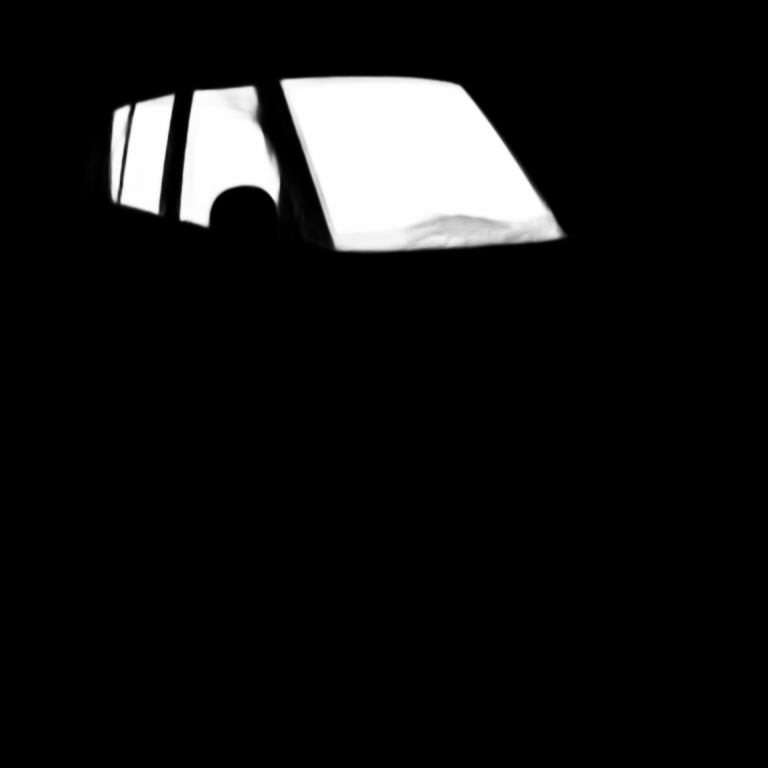

In [23]:
Image.fromarray(keras_out)

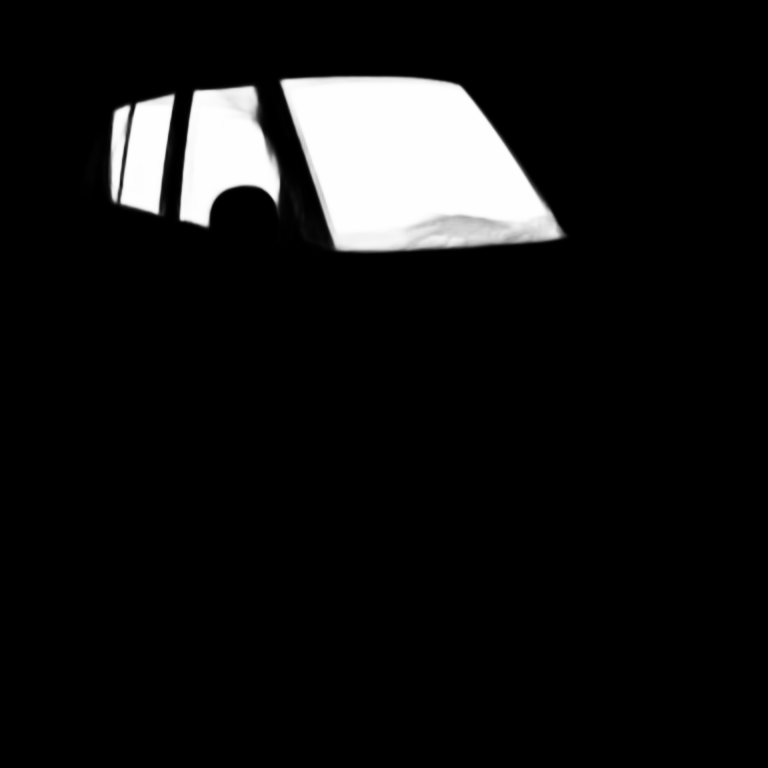

In [24]:
Image.fromarray(torch_out)

#  Trace

In [25]:
data = torch.randint(0, 255, (1, 3, 768, 768), dtype=torch.uint8, device='cuda')

In [26]:
from PIL import Image
img = Image.open("/home/azureuser/data/prop-transformed.png")
img = img.convert('RGB').resize((768,768))
data = np.array(img).transpose(2,0,1)[None]
data = torch.from_numpy(data).cuda()

In [27]:
from torch.cuda import amp

In [28]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    @torch.inference_mode()
    def forward(self, data, fp16=False):
        with amp.autocast(enabled=fp16):
            data = data.float()
            data = data.div_(255.)
            x = torch.sigmoid_(self.model(data)[0])
            return x.mul_(255.).to(torch.uint8)

In [29]:
wrp_model = WrappedModel(rbg).eval()

In [30]:
svd_out = wrp_model(data, fp16=False)

In [31]:
OUT_PATH = "/home/azureuser/triton_files/triton-model-repository/u2net_window_tint/1"

In [32]:
with torch.inference_mode(), torch.jit.optimized_execution(True):
    traced_script_module = torch.jit.trace(wrp_model, data)

In [33]:
print(traced_script_module.code)

def forward(self,
    data: Tensor) -> Tensor:
  model = self.model
  data0 = torch.to(data, 6)
  input = torch.div_(data0, CONSTANTS.c0)
  x = torch.sigmoid_((model).forward(input, ))
  x0 = torch.mul_(x, CONSTANTS.c0)
  return torch.to(x0, 0)



In [34]:
traced_script_module.save(f"{OUT_PATH}/model.pt")

In [35]:
traced_script_module = torch.jit.load(f"{OUT_PATH}/model.pt")

In [36]:
%%time
torch.cuda.synchronize()
with torch.no_grad():
    o = traced_script_module(data)
torch.cuda.synchronize()
print(o.shape)

torch.Size([1, 1, 768, 768])
CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 332 ms


In [37]:
o.shape, o.dtype

(torch.Size([1, 1, 768, 768]), torch.uint8)

In [38]:
np.testing.assert_allclose(o.cpu().numpy(), svd_out.cpu().numpy(), rtol=1e-03, atol=1e-05)